## Загружаем необходимые библиотеки

In [ ]:
import os

import random
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
from google.colab import files

import matplotlib
import plotly
import PIL
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import yaml
import torch
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

Загрузка YOLO5

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16117, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 16117 (delta 9), reused 10 (delta 1), pack-reused 16089
Receiving objects: 100% (16117/16117), 14.85 MiB | 18.67 MiB/s, done.
Resolving deltas: 100% (11028/11028), done.
/content/yolov5


In [ ]:
%cd /content/yolov5

!pip install -qr requirements.txt
!pip install -q roboflow

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.6

## Загрузка датасета




In [ ]:
!git clone 'https://github.com/MelnikDM/SVO.git'

Cloning into 'SVO'...
remote: Enumerating objects: 3545, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3545 (delta 3), reused 5 (delta 1), pack-reused 3534
Receiving objects: 100% (3545/3545), 104.54 MiB | 23.81 MiB/s, done.
Resolving deltas: 100% (1746/1746), done.


## Обработка аннотаций

И разбиение выборок на обучающую, валидационную и тестовую





In [ ]:
classes = {'MBT':0,'AIFV':1, 'APC':2, 'Vehicle':3, 'Destroyed':4}

In [ ]:
!mkdir '/content/yolov5/labels'

In [ ]:
for name in os.listdir('/content/yolov5/SVO/LA_ObjectDetection/data/Annotations'):
  with open('/content/yolov5/SVO/LA_ObjectDetection/data/Annotations/'+name, 'r') as file:
    xml_file = file.read()
    soup = BeautifulSoup(xml_file, 'xml')
    size = soup.find("size")
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    for tag in soup.findAll("object"):
      cls = tag.find("name").text
      xmin = int(tag.find("xmin").text)
      ymin = int(tag.find("ymin").text)
      xmax = int(tag.find("xmax").text)
      ymax = int(tag.find("ymax").text)

      w = xmax - xmin #вычисляем ширину бокса
      h = ymax - ymin #вычисляем высоту бокса
      x = xmin + (w / 2) #находим центр бокса по ширине
      y = ymin + (h / 2) #находим центр бокса по высоте

      #нормируем значения
      x = x / width
      w = w / width
      y = y / height
      h = h / height

      #записываем в файл
      with open('/content/yolov5/labels/'+name[:-3]+'txt', 'a') as f:
        f.write('{} {} {} {} {}\n'.format(classes[cls], x, y, w, h))

In [ ]:
image_list = os.listdir('/content/yolov5/SVO/LA_ObjectDetection/data/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2)
val_list, test_list = train_test_split(test_list, test_size=0.5)

print('Обучающая выборка: ',len(train_list))
print('Проверочная выборка: ',len(val_list))
print('Тестовая выборка:' ,len(test_list))

Обучающая выборка:  1324
Проверочная выборка:  165
Тестовая выборка: 166


In [ ]:
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/'
!mkdir '/content/yolov5/images/train/'
!mkdir '/content/yolov5/images/valid/'

mkdir: cannot create directory ‘/content/yolov5/images/’: File exists


In [ ]:
# !mkdir '/content/train/'
# !mkdir '/content/valid/'
# !mkdir '/content/train/images/'
# !mkdir '/content/valid/images'
# !mkdir '/content/train/labels'
# !mkdir '/content/valid/labels'

In [ ]:
!mkdir '/content/yolov5/labels/train/'
!mkdir '/content/yolov5/labels/valid/'

In [ ]:
def move_data(name_list, folder, newfolder, mode, img=True):
  """
  Функция перемещает файлы в указанную папку.
  name_list - список с названиями файлов для перемещения
  folder    - путь к папке откуда берем файл
  mode      - название папки куда перемещаем
  img       - указывает какой тип файла мы перемещаем
  """
  format = 'jpg' if img==True else 'txt'
  for name in name_list:
    name = name[:-3]+format
    # shutil.move(folder + name, folder + '{}/'.format(mode) + name)
    shutil.move(folder + name, newfolder + '{}/'.format(mode) + name)

In [ ]:
move_data(train_list, '/content/yolov5/SVO/LA_ObjectDetection/data/Images/', '/content/yolov5/images/', 'train', img=True)
move_data(val_list, '/content/yolov5/SVO/LA_ObjectDetection/data/Images/', '/content/yolov5/images/', 'valid', img=True)

In [ ]:
move_data(train_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'train', img=False)
move_data(val_list, '/content/yolov5/labels/', '/content/yolov5/labels/', 'valid', img=False)

## Загрузка и обучение модели Yolo_v5

In [ ]:
yaml_file = {'train':'/content/yolov5/images/train',
             'val': '/content/yolov5/images/valid',
             'nc' : '5',
             'names' : ['MBT', 'AIFV', 'APC', 'Destroyed', 'Vehicle']}

with open('helmet.yaml', 'w') as file:
    documents = yaml.dump(yaml_file, file)

Для начала создадим 2 baseline со следующими параметрами: batch 16/32, epochs 5. Веса возьмем по дефолту.

In [ ]:
!python train.py --img 640 --batch 16 --epochs 5 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-28 18:02:05.380752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 18:02:05.380817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 18:02:05.382957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, syn

In [ ]:
!python train.py --img 640 --batch 32 --epochs 5 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-28 18:07:51.730632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 18:07:51.730691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 18:07:51.732220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, syn

Продолжим наблюдения, увеличив количество эпох до 45. Батч сделаем 32

In [ ]:
!python train.py --img 640 --batch 32 --epochs 45 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt

2023-12-28 18:13:20.400011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 18:13:20.400073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 18:13:20.401629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5m.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=45, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sy

In [ ]:
!zip -r /content/file_train.zip /content/yolov5/runs/train/exp3/
files.download("/content/file_train.zip")

  adding: content/yolov5/runs/train/exp3/ (stored 0%)
  adding: content/yolov5/runs/train/exp3/labels.jpg (deflated 29%)
  adding: content/yolov5/runs/train/exp3/val_batch2_labels.jpg (deflated 7%)
  adding: content/yolov5/runs/train/exp3/train_batch2.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp3/val_batch0_labels.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp3/labels_correlogram.jpg (deflated 36%)
  adding: content/yolov5/runs/train/exp3/opt.yaml (deflated 49%)
  adding: content/yolov5/runs/train/exp3/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp3/weights/best.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp3/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp3/R_curve.png (deflated 10%)
  adding: content/yolov5/runs/train/exp3/train_batch0.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp3/events.out.tfevents.1703787203.3d10c8c99161.5945.0 (deflated 35%)
  adding: content/yolov5/runs/train/exp3/PR_curve.png (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Теперь попробуем сымитировать Transfer Learning и возьмем лучшие веса, увеличим батч до 64, а количество эпох до 70. Для ускорения заморозим первые 10 слоев модели.

In [ ]:
!python train.py --img 640 --batch 64 --epochs 70 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights /content/yolov5/runs/train/exp3/weights/best.pt --freeze 10

2023-12-28 18:55:59.998173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 18:55:59.998226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 18:55:59.999572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5/runs/train/exp3/weights/best.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False

И ради эксперимента возьмем наши лучшие гиперпараметры из прошлой модели и применим их на модели с парамерами batch 32/epochs 45.

In [ ]:
!zip -r /content/file_train_1.zip /content/yolov5/runs/train/exp4/
files.download("/content/file_train_1.zip")

  adding: content/yolov5/runs/train/exp4/ (stored 0%)
  adding: content/yolov5/runs/train/exp4/events.out.tfevents.1703789762.3d10c8c99161.16725.0 (deflated 35%)
  adding: content/yolov5/runs/train/exp4/labels.jpg (deflated 29%)
  adding: content/yolov5/runs/train/exp4/train_batch2.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp4/val_batch0_labels.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp4/labels_correlogram.jpg (deflated 36%)
  adding: content/yolov5/runs/train/exp4/opt.yaml (deflated 50%)
  adding: content/yolov5/runs/train/exp4/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp4/weights/best.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp4/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp4/R_curve.png (deflated 11%)
  adding: content/yolov5/runs/train/exp4/train_batch0.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp4/PR_curve.png (deflated 18%)
  adding: content/yolov5/runs/train/exp4/train_batch1.jpg (deflat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!python train.py --img 640 --batch 32 --epochs 45 --data /content/yolov5/helmet.yaml --cfg models/yolov5m.yaml --weights /content/yolov5/runs/train/exp4/weights/best.pt

2023-12-28 19:50:30.975952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 19:50:30.976004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 19:50:30.977624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5/runs/train/exp4/weights/best.pt, cfg=models/yolov5m.yaml, data=/content/yolov5/helmet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=45, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False

Отобразим график результатов модели batch 32/epochs 45 с гиперпараметрами от модели 64/70.

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

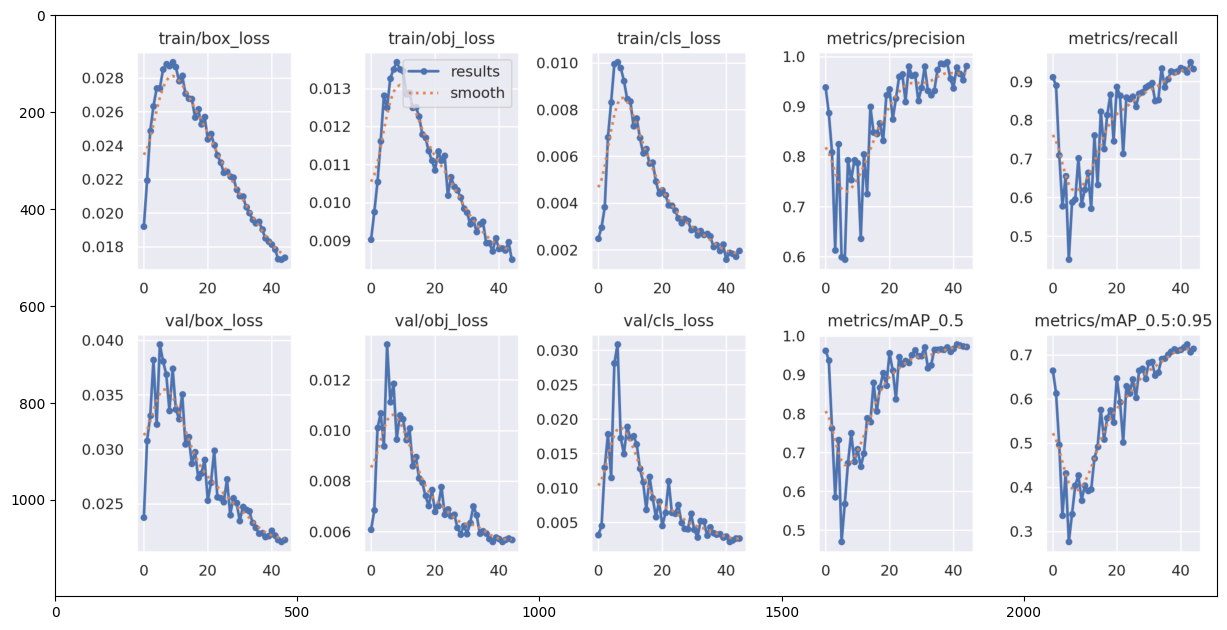

In [ ]:
img = Image.open('/content/yolov5/runs/train/exp5/results.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show

## Проверка на тестовой выборке

In [ ]:
!mkdir '/content/yolov5/images/test/'
move_data(test_list, '/content/yolov5/SVO/LA_ObjectDetection/data/Images/', '/content/yolov5/images/', 'test', img=True)

In [ ]:
!python detect.py --img 640 --source /content/yolov5/images/test/  --weights /content/yolov5/runs/train/exp5/weights/best.pt --conf 0.25

detect: weights=['/content/yolov5/runs/train/exp5/weights/best.pt'], source=/content/yolov5/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-254-gba63208 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
image 1/166 /content/yolov5/images/test/LA0005_jpg.rf.550cf542c46904365c3928bea3467593.jpg: 640x640 1 AIFV, 26.9ms
image 2/166 /content/yolov5/images/test/LA0008_jpg.rf.ecaada2685b810729e5ee0353126d98f.jpg: 640x640 1 AIFV, 27.0ms
image 3/166 /content/yolov5/images/test/LA0010_jpg.rf.d9427de9cca3ab3e5

## Выгрузка результатов

In [ ]:
!zip -r /content/file_train_2.zip /content/yolov5/runs/train/exp5/

  adding: content/yolov5/runs/train/exp5/ (stored 0%)
  adding: content/yolov5/runs/train/exp5/labels.jpg (deflated 29%)
  adding: content/yolov5/runs/train/exp5/val_batch2_labels.jpg (deflated 7%)
  adding: content/yolov5/runs/train/exp5/train_batch2.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp5/val_batch0_labels.jpg (deflated 6%)
  adding: content/yolov5/runs/train/exp5/labels_correlogram.jpg (deflated 36%)
  adding: content/yolov5/runs/train/exp5/opt.yaml (deflated 50%)
  adding: content/yolov5/runs/train/exp5/weights/ (stored 0%)
  adding: content/yolov5/runs/train/exp5/weights/best.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp5/weights/last.pt (deflated 8%)
  adding: content/yolov5/runs/train/exp5/R_curve.png (deflated 11%)
  adding: content/yolov5/runs/train/exp5/train_batch0.jpg (deflated 1%)
  adding: content/yolov5/runs/train/exp5/PR_curve.png (deflated 17%)
  adding: content/yolov5/runs/train/exp5/train_batch1.jpg (deflated 1%)
  adding: content/yolov5

In [ ]:
from google.colab import files
files.download("/content/file_train_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/file_detect.zip /content/yolov5/runs/detect/exp2/

  adding: content/yolov5/runs/detect/exp2/ (stored 0%)
  adding: content/yolov5/runs/detect/exp2/LA0217_jpg.rf.3aec8677dd6894542cce4cc56c69886b.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp2/LA0413_jpg.rf.2e76368acc9f2a620d239e888c1e78ba.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp2/LA0103_jpg.rf.4caddbd28e519f6bab3b07281ae40c42.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp2/LA0369_jpg.rf.6b200712e2311b31cbf6f34f6c3b97dd.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp2/LA0033_jpg.rf.229aba6ae58bc4294ea4aa044d9caff4.jpg (deflated 3%)
  adding: content/yolov5/runs/detect/exp2/LA0372_jpg.rf.f6b4b066ea45f9fac0cd86ebd23ab26c.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp2/LA0513_jpg.rf.d062595496edbca043c148e8ed8323c5.jpg (deflated 4%)
  adding: content/yolov5/runs/detect/exp2/LA0302_jpg.rf.b3ca3fc19d49003e0f8ae81cf6380f9f.jpg (deflated 5%)
  adding: content/yolov5/runs/detect/exp2/LA0107_jpg.rf.c4a9e7404fff003df8f2c91513885dd1.

In [ ]:
from google.colab import files
files.download("/content/file_detect.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>